In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score
from scipy.stats import entropy
from scipy.spatial.distance import cdist
import pandas as pd

# === Toy Datasets ===
def sample_8gaussians(batch_size,imbalance = 1):
    scale = 1.0
    centers = [(scale * np.cos(2 * np.pi * i / 8), scale * np.sin(2 * np.pi * i / 8)) for i in range(8)]
    centers = np.array(centers)
    indices = np.random.choice(8, p=np.array([imbalance,1]*4)/sum([3,1]*4), size=batch_size)
    samples = centers[indices] + 0.05 * np.random.randn(batch_size, 2)
    return torch.tensor(samples, dtype=torch.float32)

def sample_rings(batch_size, num_rings=2, points_per_ring=8, radius_gap=0.3, std=0.05):
    radii = [1 + i * radius_gap for i in range(num_rings)]
    angles = np.random.uniform(0, 2 * np.pi, batch_size)
    centers = [(r * np.cos(a), r * np.sin(a)) for r in radii for a in angles]
    centers = np.array(centers)
    indices = np.random.randint(0, len(centers), size=batch_size)
    samples = centers[indices] + std * np.random.randn(batch_size, 2)
    return torch.tensor(samples, dtype=torch.float32)

# === Beta schedule ===
def cosine_beta_schedule(timesteps, s=0.008):
    x = torch.linspace(0, timesteps, timesteps + 1)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 1e-5, 0.999)

# === Sinusoidal Time Embedding ===
def get_sinusoidal_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

# === Model ===
class DiffusionMLP(nn.Module):
    def __init__(self, hidden_dim=256, time_embed_dim=64):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.net = nn.Sequential(
            nn.Linear(2 + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Removed Tanh for unbounded output
        )

    def forward(self, x, t):
        t_embed = get_sinusoidal_embedding(t.view(-1), self.time_embed_dim).to(x.device)
        x_in = torch.cat([x, t_embed], dim=1)
        return self.net(x_in)

# === Forward process ===
def q_sample(x0, t, noise, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod):
    s_ac = sqrt_alpha_cumprod[t].view(-1, 1).to(x0.device)
    s_om = sqrt_one_minus_alpha_cumprod[t].view(-1, 1).to(x0.device)
    return s_ac * x0 + s_om * noise

# === Reverse sampling ===
def sample_reverse(model, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, n_samples):
    model.eval()
    x = torch.randn(n_samples, 2).to(next(model.parameters()).device)
    for t in reversed(range(T)):
        t_tensor = torch.full((n_samples,), t, dtype=torch.long, device=x.device)
        with torch.no_grad():
            pred_noise = model(x, t_tensor)
        beta_t = betas[t]
        alpha_t = sqrt_alpha[t] ** 2
        coef1 = 1 / sqrt_alpha[t]
        coef2 = beta_t / torch.sqrt(1 - alpha_t)
        x = coef1 * (x - coef2 * pred_noise)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta_t)
            x = x + sigma * noise
    return x

# === Evaluation Metrics ===
def count_modes(samples, threshold=0.1):
    scale = 1.0
    centers = [(scale * np.cos(2 * np.pi * i / 8), scale * np.sin(2 * np.pi * i / 8)) for i in range(8)]
    centers = torch.tensor(centers, dtype=torch.float32)
    found = torch.zeros(len(centers), dtype=torch.bool)
    for i, c in enumerate(centers):
        dists = torch.norm(samples - c.unsqueeze(0), dim=1)
        if (dists < threshold).any():
            found[i] = True
    return found.sum().item()

def compute_wasserstein(real, fake):
    dists = cdist(real.numpy(), fake.numpy())
    return dists.min(axis=1).mean()

def compute_kl(real, fake, bins=100):
    all_data = torch.cat([real, fake], dim=0)
    hist_range = [[all_data[:, 0].min(), all_data[:, 0].max()], [all_data[:, 1].min(), all_data[:, 1].max()]]
    H_real, _, _ = np.histogram2d(real[:, 0].numpy(), real[:, 1].numpy(), bins=bins, range=hist_range)
    H_fake, _, _ = np.histogram2d(fake[:, 0].numpy(), fake[:, 1].numpy(), bins=bins, range=hist_range)
    H_real += 1e-8
    H_fake += 1e-8
    P = H_real.flatten() / H_real.sum()
    Q = H_fake.flatten() / H_fake.sum()
    return entropy(P, Q)

# === Training ===
def train_adv(model, optimizer, T, betas, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod, sqrt_alpha, adv_eps=0.2, n_steps=5000, batch_size=512, device=None,sample_fn = sample_8gaussians):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    metrics = []
    for step in range(n_steps):
        x0 = sample_fn(batch_size).to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod)

        # Adversarial step: FGSM
        xt_adv = xt.clone().detach().requires_grad_(True)
        pred = model(xt_adv, t)
        loss = F.mse_loss(pred, noise)
        loss.backward()
        perturb = adv_eps * xt_adv.grad.data.sign()
        xt_adv = (xt_adv + perturb).detach()

        pred_adv = model(xt_adv, t)
        loss_adv = F.mse_loss(pred_adv, noise)
        optimizer.zero_grad()
        loss_adv.backward()
        optimizer.step()

        if step % 500 == 0:
            with torch.no_grad():
                samples = sample_reverse(model, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, 1000).cpu()
                real = sample_8gaussians(1000)
                wasserstein = compute_wasserstein(real, samples)
                kl = compute_kl(real, samples)
                modes = count_modes(samples)
                print(f"[ADV] Step {step}: loss={loss_adv.item():.4f}, modes={modes}, W={wasserstein:.4f}, KL={kl:.4f}")
                metrics.append({"step": step, "loss": loss_adv.item(), "modes": modes, "wasserstein": wasserstein, "kl": kl})
    return pd.DataFrame(metrics)
def train(model, optimizer, T, betas, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod, sqrt_alpha, n_steps=5000, batch_size=512, device=None,sample_fn = sample_8gaussians):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    metrics = []
    for step in range(n_steps):
        x0 = sample_fn(batch_size).to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod)

        pred = model(xt, t)
        loss = F.mse_loss(pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            with torch.no_grad():
                samples = sample_reverse(model, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, 1000).cpu()
                real = sample_8gaussians(1000)
                wasserstein = compute_wasserstein(real, samples)
                kl = compute_kl(real, samples)
                modes = count_modes(samples)
                print(f"Step {step}: loss={loss.item():.4f}, modes={modes}, W={wasserstein:.4f}, KL={kl:.4f}")
                metrics.append({"step": step, "loss": loss.item(), "modes": modes, "wasserstein": wasserstein, "kl": kl})
    return pd.DataFrame(metrics)

# === Sampling Visualization ===
def plot_samples(model, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, title):
    samples = sample_reverse(model, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, 1000).cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.6)
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# === Plotting ===
def plot_comparison(df_base, df_adv):
    plt.figure(figsize=(14, 6))
    metrics = ['loss', 'modes', 'wasserstein', 'kl']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(df_base['step'], df_base[metric], label='Base', linewidth=2)
        plt.plot(df_adv['step'], df_adv[metric], label='Adversarial', linewidth=2, linestyle='--')
        plt.title(metric.capitalize())
        plt.xlabel("Step")
        plt.grid(True)
        if metric == 'modes':
            plt.yticks(range(0, 9))
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_metrics(df, label):
    plt.figure(figsize=(12, 4))
    for metric in ['loss', 'modes', 'wasserstein', 'kl']:
        plt.plot(df['step'], df[metric], label=f'{label} {metric}')
    plt.xlabel("Step")
    plt.ylabel("Metric value")
    plt.title("Diffusion Training Metrics")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
sample_fn = lambda batch_size: sample_8gaussians(batch_size,)

In [103]:
model_base = DiffusionMLP()
model_adv = DiffusionMLP()
optimizer_base = Adam(model_base.parameters(), lr=1e-3)
optimizer_adv = Adam(model_adv.parameters(), lr=1e-3)

In [104]:
T = 10
betas = cosine_beta_schedule(T)
sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1 - betas, dim=0))
sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - torch.cumprod(1 - betas, dim=0))
sqrt_alpha = torch.sqrt(1 - betas)
df_base = train(model_base, optimizer_base, T, betas, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod, sqrt_alpha,n_steps=20_000,sample_fn=sample_fn)

Step 0: loss=1.0660, modes=0, W=14.6463, KL=11.7528
Step 500: loss=0.3646, modes=8, W=0.0345, KL=16.5712
Step 1000: loss=0.3137, modes=8, W=0.0345, KL=16.2744
Step 1500: loss=0.3620, modes=8, W=0.0343, KL=16.5179
Step 2000: loss=0.3481, modes=8, W=0.0327, KL=15.9590
Step 2500: loss=0.3511, modes=8, W=0.0304, KL=15.4036
Step 3000: loss=0.3690, modes=8, W=0.0314, KL=15.8871
Step 3500: loss=0.3487, modes=8, W=0.0331, KL=15.9288
Step 4000: loss=0.2896, modes=8, W=0.0270, KL=14.8859
Step 4500: loss=0.3371, modes=8, W=0.0275, KL=15.6024
Step 5000: loss=0.3867, modes=8, W=0.0343, KL=16.4651
Step 5500: loss=0.3485, modes=8, W=0.0300, KL=15.1412
Step 6000: loss=0.3241, modes=8, W=0.0312, KL=15.6688
Step 6500: loss=0.3554, modes=8, W=0.0241, KL=14.1229
Step 7000: loss=0.3350, modes=8, W=0.0313, KL=15.7830
Step 7500: loss=0.3467, modes=8, W=0.0262, KL=14.6592
Step 8000: loss=0.3017, modes=8, W=0.0255, KL=14.4396
Step 8500: loss=0.3528, modes=8, W=0.0275, KL=14.8284
Step 9000: loss=0.3351, modes=8

In [105]:
T = 10
betas = cosine_beta_schedule(T)
sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1 - betas, dim=0))
sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - torch.cumprod(1 - betas, dim=0))
sqrt_alpha = torch.sqrt(1 - betas)
df_adv = train_adv(model_adv, optimizer_adv, T, betas, sqrt_alpha_cumprod, sqrt_one_minus_alpha_cumprod, sqrt_alpha,n_steps=20_000,adv_eps=0.03,sample_fn=sample_fn)

[ADV] Step 0: loss=1.0131, modes=0, W=5.6965, KL=22.5098
[ADV] Step 500: loss=0.4012, modes=8, W=0.0360, KL=16.2608
[ADV] Step 1000: loss=0.4012, modes=8, W=0.0324, KL=15.2923
[ADV] Step 1500: loss=0.4103, modes=8, W=0.0327, KL=16.3300
[ADV] Step 2000: loss=0.3170, modes=8, W=0.0308, KL=15.6633
[ADV] Step 2500: loss=0.3865, modes=8, W=0.0299, KL=16.2251
[ADV] Step 3000: loss=0.3810, modes=8, W=0.0321, KL=15.3979
[ADV] Step 3500: loss=0.3901, modes=8, W=0.0343, KL=16.4018
[ADV] Step 4000: loss=0.3531, modes=8, W=0.0323, KL=15.5298
[ADV] Step 4500: loss=0.3693, modes=8, W=0.0346, KL=16.4376
[ADV] Step 5000: loss=0.3585, modes=8, W=0.0312, KL=15.9728
[ADV] Step 5500: loss=0.3557, modes=8, W=0.0335, KL=16.4779
[ADV] Step 6000: loss=0.4097, modes=8, W=0.0292, KL=15.7194
[ADV] Step 6500: loss=0.3858, modes=8, W=0.0281, KL=15.1130
[ADV] Step 7000: loss=0.3743, modes=8, W=0.0350, KL=15.8001
[ADV] Step 7500: loss=0.3884, modes=8, W=0.0305, KL=15.0268
[ADV] Step 8000: loss=0.3388, modes=8, W=0.0

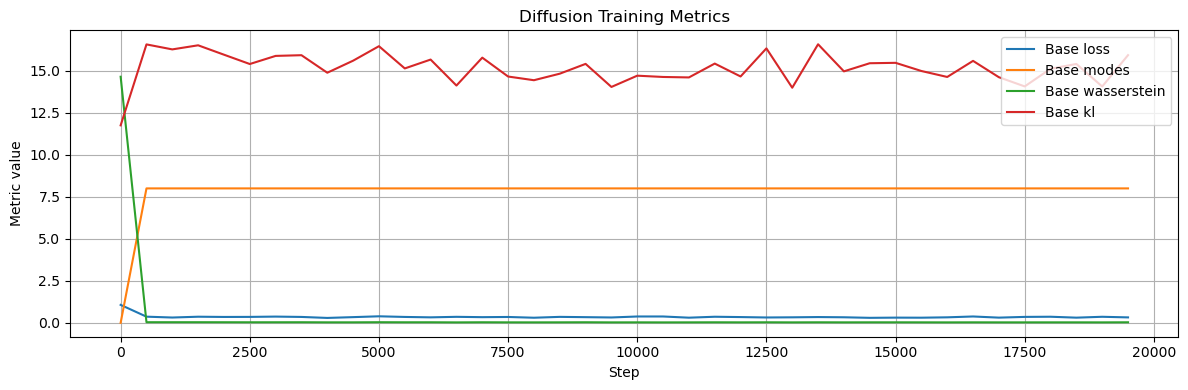

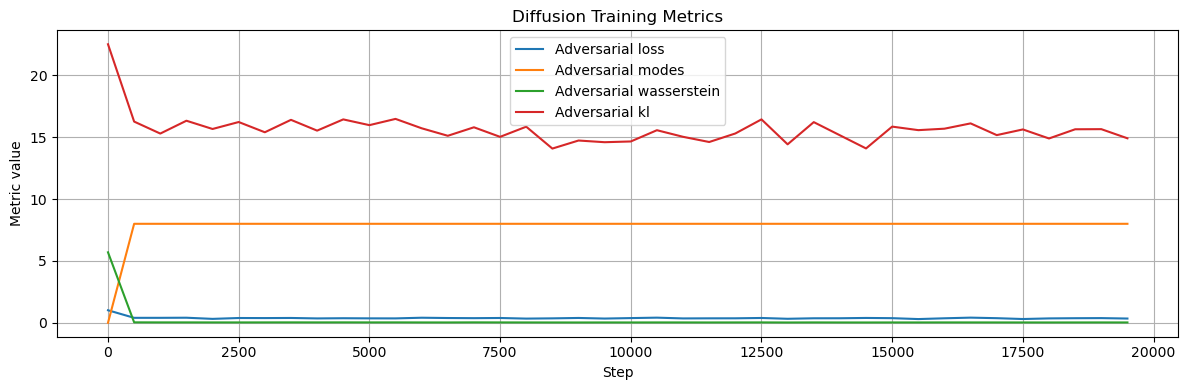

In [106]:
plot_metrics(df_base, label="Base")
plot_metrics(df_adv, label="Adversarial")

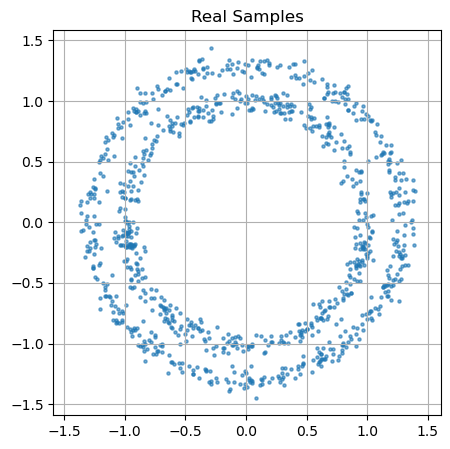

In [107]:
sample = sample_fn(1000)

plt.figure(figsize=(5, 5))
plt.scatter(sample[:, 0], sample[:, 1], s=5, alpha=0.6)
plt.title('Real Samples')
plt.axis('equal')
plt.grid(True)
plt.show()

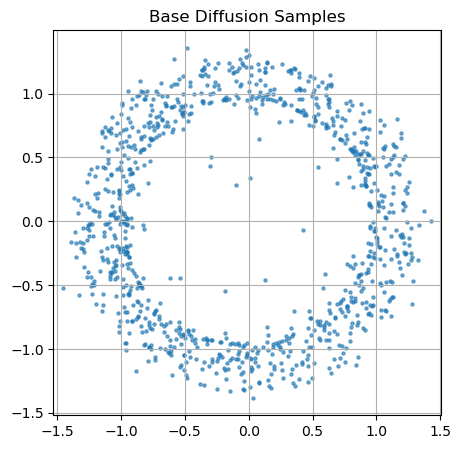

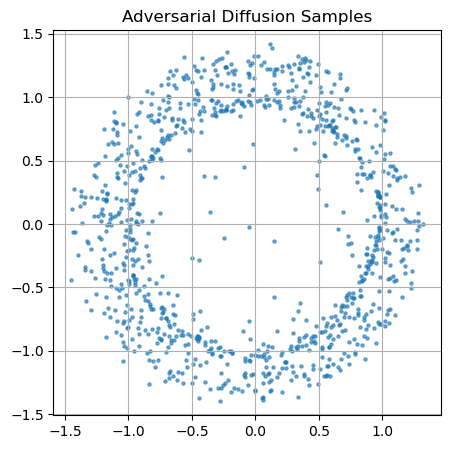

In [108]:
plot_samples(model_base, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, "Base Diffusion Samples")
plot_samples(model_adv, betas, sqrt_alpha, sqrt_one_minus_alpha_cumprod, T, "Adversarial Diffusion Samples")


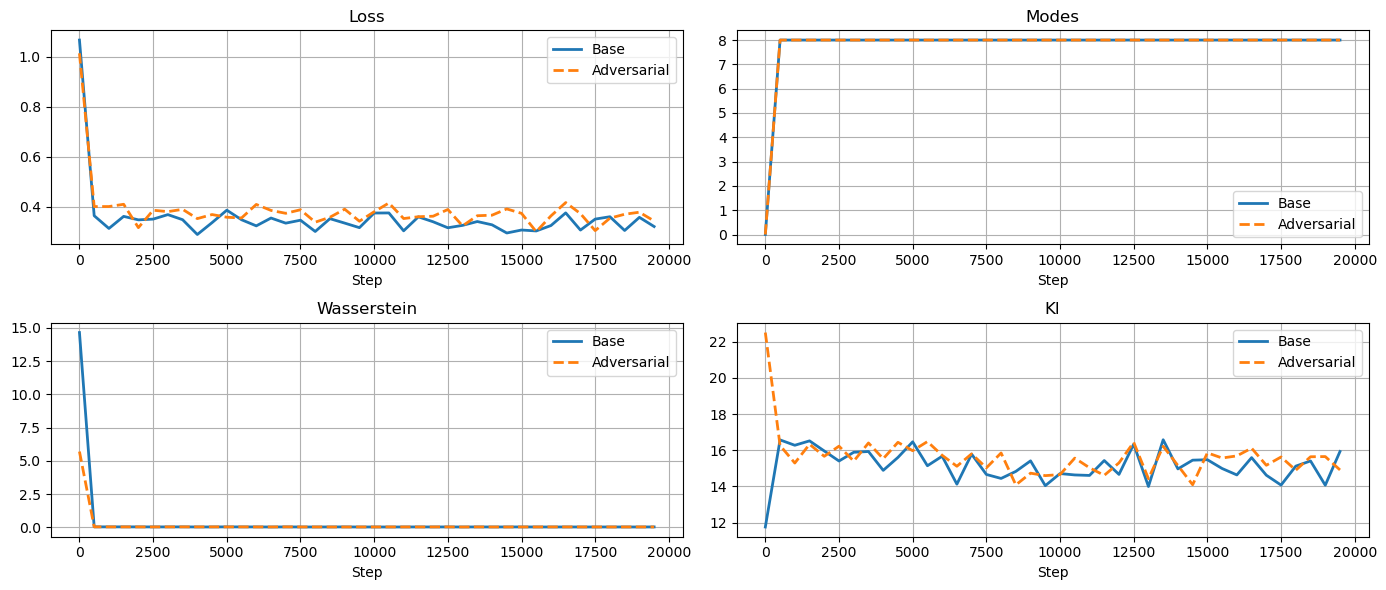

In [109]:
plot_comparison(df_base, df_adv)
